# Crack Detection Binary Classification

This dataset is made up of images of buildings and structures with cracks and without. The goal of the project is to build a model that is able to distinguish between the two and make highly accurate predictions on new unseen images.

## Imports

In [1]:
# -----------------
# Import libararies
# -----------------
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from shutil import copyfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import gradio as gr
from torchvision import transforms
import shutil


# -----------------
# Extract Zip File
# -----------------
local_zip = '/Users/miesner.jacob/kaggle/crack_detection/crack-identification-ce784a-2020-iitk.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## Create file-structure to separate data

In [2]:
# -----------------------
# Confirming image counts
# -----------------------
base_path = '/tmp/'
# shutil.move('/tmp/test','/tmp/test_images/test')

train_dir = os.path.join(base_path, 'train/')
test_dir = os.path.join(base_path, 'test_images/test')

cracked_dir = os.path.join(train_dir, 'cracked/')
uncracked_dir = os.path.join(train_dir, 'uncracked/')

print(f'Total Train images {len(os.listdir(os.path.join(cracked_dir)))+len(os.listdir(os.path.join(uncracked_dir)))}')
print(f'Total Test images {len(os.listdir(os.path.join(test_dir)))}')

Total Train images 14968
Total Test images 2001


In [3]:
# -----------------------
# Confirming image counts
# -----------------------
cracked_dir = os.path.join(train_dir, 'cracked/')
uncracked_dir = os.path.join(train_dir, 'uncracked/')

print(f'Total Cracked images {len(os.listdir(os.path.join(cracked_dir)))}')
print(f'Total Uncracked images {len(os.listdir(os.path.join(uncracked_dir)))}')

Total Cracked images 7501
Total Uncracked images 7467


## Loading in Inception V3 model for transfer learning!

The reason I am using transfer learning in this problem is that there is not a lot of data to train on, therefore using weights trained for another task and fine tuning it using my data is a good fit.

In [4]:
# --------------------------------------------------
# Loading weights and applying to inception model
# --------------------------------------------------
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(256, 256, 3),
                                include_top=False,
                                weights=None)
model = pre_trained_model

pre_trained_model.load_weights(local_weights_file)

# --------------------------------------------------
# Make all layers in pre-trained model not trainable
# --------------------------------------------------
for layer in pre_trained_model.layers:
    pre_trained_model.trainable = False
    
# --------------------------------------------------
# Getting last layer outuput to connect to fine-tuned
# DNN attached for transfer learning
# --------------------------------------------------
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 768)


In [5]:
# ---------------------
# Defining DNN to train
# ---------------------

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

## Specify optimizer, create checkpoint model files, Augment training data

In [6]:
# ----------------
# Define Optimizer
# ----------------
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

In [7]:
# ------------------------------------
# Saving model using Checkpoint method
# ------------------------------------
filepath="best_model_file.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)

In [8]:
# ---------------
# Compiling model
# ---------------
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# ---------------------------------------
# Using Data Augmentation to have more
# data to train on and for regularization
# ---------------------------------------
train_datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=.5,
    height_shift_range=0.5,
    zoom_range=.5,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,1.0],
    fill_mode='nearest',
    validation_split=0.3
)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    target_size=(256, 256),
                                                    class_mode='binary',
                                                    classes=['cracked','uncracked'],
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    target_size=(256, 256),
                                                    class_mode='binary',
                                                    classes=['cracked','uncracked'],
                                                    subset='validation')

Found 10478 images belonging to 2 classes.
Found 4490 images belonging to 2 classes.


In [10]:
# -----------------------
# Creating Test Generator
# -----------------------
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=64,
                                                  target_size=(256, 256),
                                                  class_mode=None,
                                                  shuffle=False)

Found 2000 images belonging to 1 classes.


## Training!

In [11]:
# --------------
# Training Model
# --------------
history = model.fit(train_generator,
                    batch_size=64,
                    epochs=10,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])

Epoch 1/10
164/164 [==============================] - 670s 4s/step - loss: 0.6567 - accuracy: 0.6349 - val_loss: 0.5927 - val_accuracy: 0.6584
Epoch 2/10
164/164 [==============================] - 619s 4s/step - loss: 0.5946 - accuracy: 0.6701 - val_loss: 0.5605 - val_accuracy: 0.6976
Epoch 3/10
164/164 [==============================] - 595s 4s/step - loss: 0.5719 - accuracy: 0.6833 - val_loss: 0.5626 - val_accuracy: 0.6817
Epoch 4/10
164/164 [==============================] - 596s 4s/step - loss: 0.5659 - accuracy: 0.6928 - val_loss: 0.5607 - val_accuracy: 0.6869
Epoch 5/10
164/164 [==============================] - 594s 4s/step - loss: 0.5656 - accuracy: 0.6935 - val_loss: 0.5402 - val_accuracy: 0.7160
Epoch 6/10
164/164 [==============================] - 662s 4s/step - loss: 0.5638 - accuracy: 0.6893 - val_loss: 0.5412 - val_accuracy: 0.7071
Epoch 7/10
164/164 [==============================] - 615s 4s/step - loss: 0.5541 - accuracy: 0.6982 - val_loss: 0.5477 - val_accuracy: 0.7007

This model struggled to learn. Improvements that could be made include confirming the labels in the training and test data, training a different model architecture, training a larger model, and training for longer, and additional hyperparameter tuning.

## Training evalutaion

Text(0.5, 1.0, 'Training and validation loss')

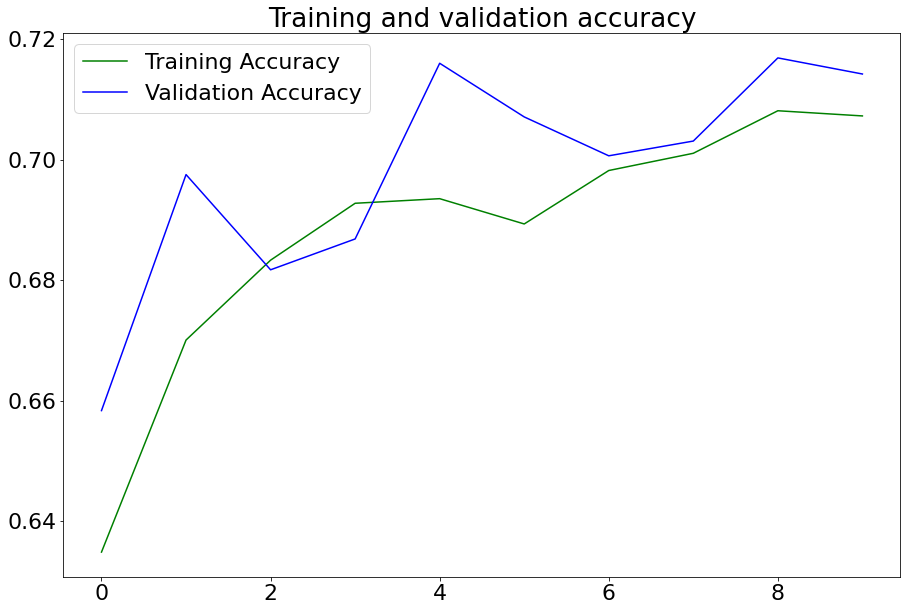

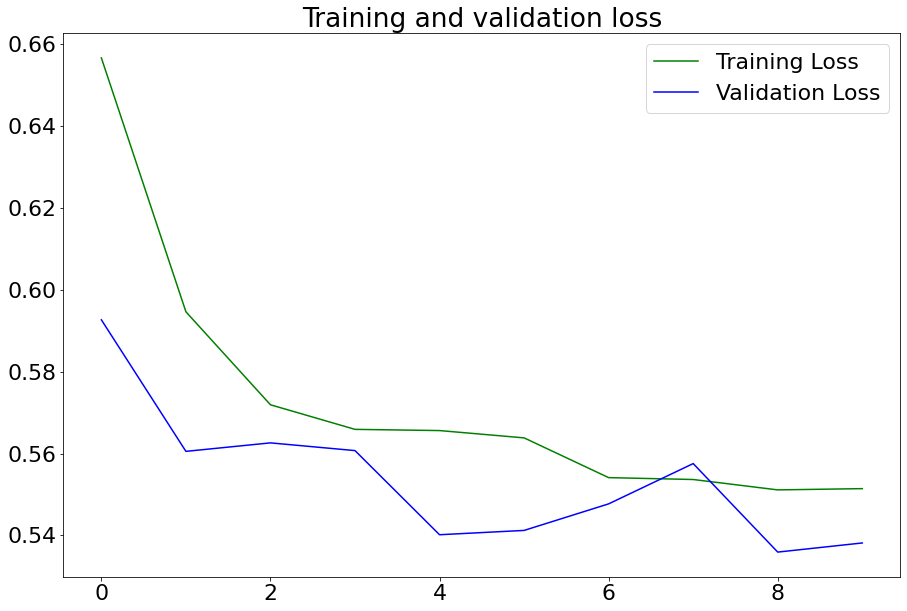

In [12]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
# ---------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
# ---------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Get number of epochs

# -----------------------------------------------
# Plot training and validation accuracy per epoch
# -----------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs, acc, '-g', label="Training Accuracy")
plt.plot(epochs, val_acc, '-b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()

# -------------------------------------------
# Plot training and validation loss per epoch
# -------------------------------------------
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, '-g', label="Training Loss")
plt.plot(epochs, val_loss, '-b', label="Validation Loss")
plt.legend()
plt.title('Training and validation loss')

# Predictions

In [13]:
probabilities = model.predict_generator(test_generator)

Instructions for updating:
Please use Model.predict, which supports generators.


In [14]:
probabilities

array([[2.8812212e-01],
       [5.6675625e-01],
       [3.9993197e-01],
       ...,
       [6.9257110e-01],
       [3.2411986e-06],
       [3.6209470e-01]], dtype=float32)

In [15]:
import numpy as np

In [16]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
class_dict= train_generator.class_indices # a dictionary where key is the class name and value is the corresponding label for the class
print (class_dict) # have a look at the dictionary
new_dict={} 
for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value=class_dict[key]
    new_dict[value]=key
print('PREDICTED CLASS   FILENAME ' ) # adjust spacing based on your class names
for i, p in enumerate(probabilities):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    file=test_file_names[i]
    print(f'    {pred_class}      {file}')

{'cracked': 0, 'uncracked': 1}
PREDICTED CLASS   FILENAME 
    cracked      test/1.jpg
    cracked      test/10.jpg
    cracked      test/100.jpg
    cracked      test/1000.jpg
    cracked      test/1001.jpg
    cracked      test/1002.jpg
    cracked      test/1003.jpg
    cracked      test/1004.jpg
    cracked      test/1005.jpg
    cracked      test/1006.jpg
    cracked      test/1007.jpg
    cracked      test/1008.jpg
    cracked      test/1009.jpg
    cracked      test/101.jpg
    cracked      test/1010.jpg
    cracked      test/1011.jpg
    cracked      test/1012.jpg
    cracked      test/1013.jpg
    cracked      test/1014.jpg
    cracked      test/1015.jpg
    cracked      test/1016.jpg
    cracked      test/1017.jpg
    cracked      test/1018.jpg
    cracked      test/1019.jpg
    cracked      test/102.jpg
    cracked      test/1020.jpg
    cracked      test/1021.jpg
    cracked      test/1022.jpg
    cracked      test/1023.jpg
    cracked      test/1024.jpg
    cracked      te

    cracked      test/1820.jpg
    cracked      test/1821.jpg
    cracked      test/1822.jpg
    cracked      test/1823.jpg
    cracked      test/1824.jpg
    cracked      test/1825.jpg
    cracked      test/1826.jpg
    cracked      test/1827.jpg
    cracked      test/1828.jpg
    cracked      test/1829.jpg
    cracked      test/183.jpg
    cracked      test/1830.jpg
    cracked      test/1831.jpg
    cracked      test/1832.jpg
    cracked      test/1833.jpg
    cracked      test/1834.jpg
    cracked      test/1835.jpg
    cracked      test/1836.jpg
    cracked      test/1837.jpg
    cracked      test/1838.jpg
    cracked      test/1839.jpg
    cracked      test/184.jpg
    cracked      test/1840.jpg
    cracked      test/1841.jpg
    cracked      test/1842.jpg
    cracked      test/1843.jpg
    cracked      test/1844.jpg
    cracked      test/1845.jpg
    cracked      test/1846.jpg
    cracked      test/1847.jpg
    cracked      test/1848.jpg
    cracked      test/1849.jpg
    cracke

    cracked      test/906.jpg
    cracked      test/907.jpg
    cracked      test/908.jpg
    cracked      test/909.jpg
    cracked      test/91.jpg
    cracked      test/910.jpg
    cracked      test/911.jpg
    cracked      test/912.jpg
    cracked      test/913.jpg
    cracked      test/914.jpg
    cracked      test/915.jpg
    cracked      test/916.jpg
    cracked      test/917.jpg
    cracked      test/918.jpg
    cracked      test/919.jpg
    cracked      test/92.jpg
    cracked      test/920.jpg
    cracked      test/921.jpg
    cracked      test/922.jpg
    cracked      test/923.jpg
    cracked      test/924.jpg
    cracked      test/925.jpg
    cracked      test/926.jpg
    cracked      test/927.jpg
    cracked      test/928.jpg
    cracked      test/929.jpg
    cracked      test/93.jpg
    cracked      test/930.jpg
    cracked      test/931.jpg
    cracked      test/932.jpg
    cracked      test/933.jpg
    cracked      test/934.jpg
    cracked      test/935.jpg
    cracked  